In [35]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from  statsmodels.tsa.stattools import adfuller,kpss 
import statsmodels.api
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.svm import SVR
#from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
#from hmmlearn import hmm

In [3]:
#format data
data=pd.read_csv('AMZN.csv')
data['Local time']=[data['Local time'][i].replace(' GMT+0300','')for i in range(len(data['Local time']))]
data['time']=[data['Local time'][i].replace('.','/',2)for i in range(len(data['Local time']))]
data['time']=[datetime.strptime(data['time'][i], '%d/%m/%Y %H:%M:%S.%f') for i in range(len(data['Local time']))]

In [29]:
#calculate midprice
data['Mid']=(data['Ask']+data['Bid'])/2
data['totalvolume']=data['AskVolume']+data['BidVolume']
#dat=data[['time','Mid']]
#dat.info()


In [5]:
#test for autocorrelation (Ljung-Box test of autocorrelation in residuals)
statsmodels.stats.diagnostic.acorr_ljungbox(data['Mid'])[1]
#there is autocorrelation present

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

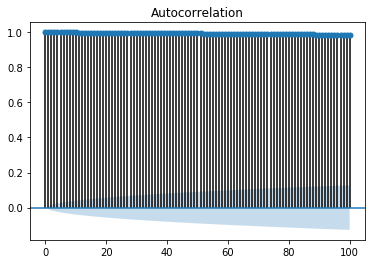

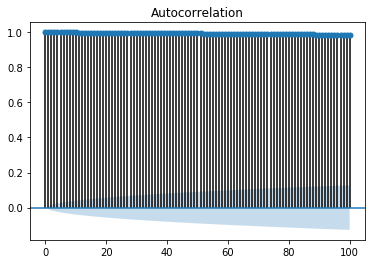

In [6]:
plot_acf(data['Mid'],lags=100)#no decrease in autocorrelation even after 100 lags
#slow decrease, does not converge to zero, a sign of non-stationarity

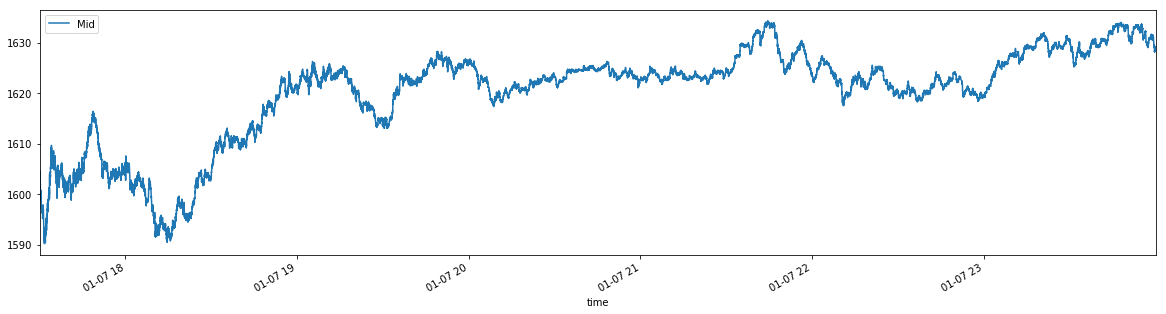

In [7]:
data.plot('time','Mid',figsize=(20,5))
plt.show()
#trend is obviuos, indicating varyinfg mean->non-stationary.Still, perform ADF and KPSS tests on stationarity

In [8]:
data.index=pd.DatetimeIndex(data['time'])
data.drop(columns=['Local time'])
data.head(3)

,Local time,Ask,Bid,AskVolume,BidVolume,time,Mid
time,,,,,,,
2019-01-07 17:30:00.070,07.01.2019 17:30:00.070,1603.113,1602.287,0.0001,0.0000,2019-01-07 17:30:00.070,1602.700
2019-01-07 17:30:00.157,07.01.2019 17:30:00.157,1604.452,1601.298,0.0001,0.0002,2019-01-07 17:30:00.157,1602.875
2019-01-07 17:30:00.258,07.01.2019 17:30:00.258,1604.453,1602.287,0.0002,0.0000,2019-01-07 17:30:00.258,1603.370


In [9]:
#midprice=np.array(dat['Mid'])
adfuller(data['Mid'],maxlag=7)
#p-value is 38%, so we detect non-stationarity

(-1.7997707426728153,
 0.38057551944593515,
 7,
 46549,
 {'1%': -3.430490489820316,
  '5%': -2.8616020935138544,
  '10%': -2.5668030503414685},
 -45848.89722598923)

In [10]:
#KPSS test
kpss(data['Mid'])
#p-value<1%, with 56 lags. So, this test tells that there is  nonstationarity (Ho:sationary)

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(54.7201516040537,
 0.01,
 56,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [11]:
delt=data.loc[:,'Mid']
delt=delt.diff(periods=1)
delt[0]=0
adfuller(delt,maxlag=7) #differencing removes non-stationarity, so work with new data

(-81.97771431870177,
 0.0,
 6,
 46550,
 {'1%': -3.4304904868021087,
  '5%': -2.8616020921799024,
  '10%': -2.566803049631444},
 -45847.65753760439)

In [12]:
data['delt']=delt
data.iloc[0,-1]=0
data.head(3)

,Local time,Ask,Bid,AskVolume,BidVolume,time,Mid,delt
time,,,,,,,,
2019-01-07 17:30:00.070,07.01.2019 17:30:00.070,1603.113,1602.287,0.0001,0.0000,2019-01-07 17:30:00.070,1602.700,0.000
2019-01-07 17:30:00.157,07.01.2019 17:30:00.157,1604.452,1601.298,0.0001,0.0002,2019-01-07 17:30:00.157,1602.875,0.175
2019-01-07 17:30:00.258,07.01.2019 17:30:00.258,1604.453,1602.287,0.0002,0.0000,2019-01-07 17:30:00.258,1603.370,0.495


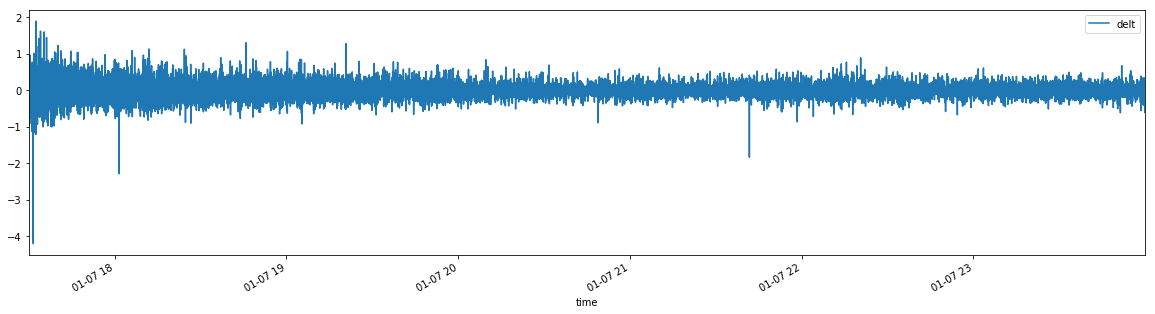

In [13]:
data.plot('time','delt',figsize=(20,5))

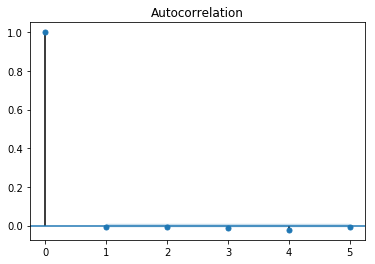

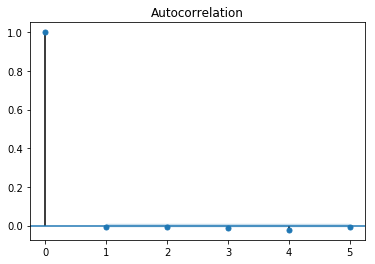

In [14]:
plot_acf(data['delt'],lags=5)#no autocorrelation between lags

In [15]:
#data['time']=str(data['time'])
date_range=list(range(len(delt)))
data_for_split=pd.DataFrame([date_range,pd.Series(np.ones(len(delt))),data['delt']],)

In [16]:
#test and trainings sets for delta
data_for_split=np.transpose(data_for_split)
data_for_split.columns=['date','intercept','delt']
tss = TimeSeriesSplit(n_splits = 2)
X=data_for_split[['intercept','date']]
Y=data_for_split[['delt']]
for train_index, test_index in tss.split(X):
    xtrain, xtest = X.iloc[train_index, :], X.iloc[test_index,:]
    ytrain, ytest = Y.iloc[train_index], Y.iloc[test_index]
    
xtraindel=np.array(xtrain)
xtraindel=xtraindel.reshape(xtraindel.shape[0],2)
ytraindel=np.array(ytrain).reshape(ytrain.shape[0],)
xtestdel=np.array(xtest).reshape(xtest.shape[0],2)
ytestdel=np.array(ytest).reshape(ytest.shape[0],)


In [17]:
#test and trainings sets for price
data_splt=pd.DataFrame([date_range,pd.Series(np.ones(len(delt))),data['Mid']],)
data_splt=np.transpose(data_splt)
data_splt.columns=['date','intercept','Mid']
tss = TimeSeriesSplit(n_splits = 2)
X1=data_splt[['intercept','date']]
Y1=data_splt[['Mid']]
for train_index, test_index in tss.split(X):
    xtrainmid, xtestmid = X1.iloc[train_index, :], X1.iloc[test_index,:]
    ytrainmid, ytestmid = Y1.iloc[train_index], Y1.iloc[test_index]
    
xtrainmid=np.array(xtrainmid)
xtrainmid=xtrainmid.reshape(xtrainmid.shape[0],2)
ytrainmid=np.array(ytrainmid).reshape(ytrainmid.shape[0],)
xtestmid=np.array(xtestmid).reshape(xtestmid.shape[0],2)
ytestmid=np.array(ytestmid).reshape(ytestmid.shape[0],)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(xtraindel, ytraindel)
plt.figure(figsize=(10,5))
plt.plot(ytestdel[:10])
plt.plot(knn.predict(xtestdel[:10,:]))
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(xtrainmid, ytrainmid)
plt.figure(figsize=(10,5))
plt.plot(ytestmid)
plt.plot(knn.predict(xtestmid))
plt.show()

In [ ]:
for k in ['linear','poly','rbf','sigmoid']:
    clf = SVR(kernel=k)
    clf.fit(xtrainmid, ytrainmid)
    confidence = clf.score(xtrainmid, ytrainmid)
    print(k,confidence)

In [19]:
Svr=SVR(C=1.0, epsilon=0.2)
Svr.fit(xtrainmid, ytrainmid)
#print(Svr.score(regr, date))
#Svr.predict()
plt.figure(figsize=(10,5))
plt.plot(ytestmid)
plt.plot(Svr.predict(xtestmid))
plt.show()

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
HMM= hmm.GaussianHMM(3, "full")
HMM.fit(xtrainmid)

NameError: name 'hmm' is not defined

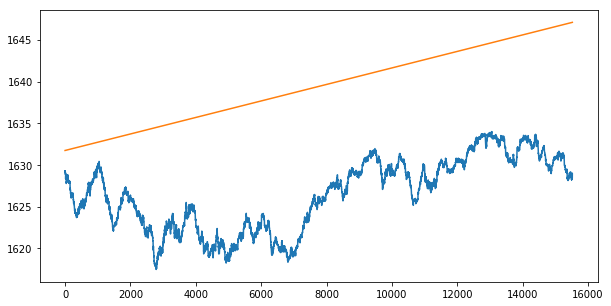

In [26]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(xtrainmid,ytrainmid)
plt.figure(figsize=(10,5))
plt.plot(ytestmid)
plt.plot(lin.predict(xtestmid))
plt.show()

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.50531e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.80251e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.38289e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.14165e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.03074e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.p

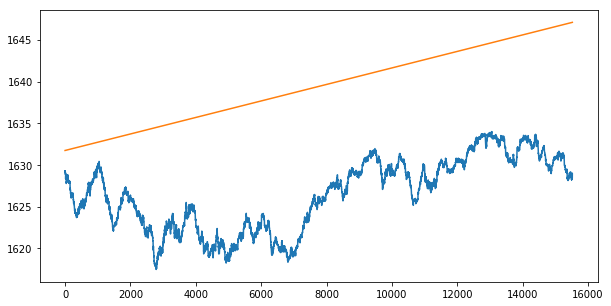

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
alphas = np.logspace(-5,3,20)

clf = GridSearchCV(estimator=linear_model.Ridge(), param_grid=dict(alpha=alphas), cv=10)
clf.fit(xtrainmid,ytrainmid)
plt.figure(figsize=(10,5))
plt.plot(ytestmid)
plt.plot(clf.predict(xtestmid))
plt.show()

In [34]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1, random_state = 2)
# Train the model on training data
rf.fit(xtrainmid,ytrainmid)
plt.figure(figsize=(10,5))
plt.plot(ytestmid)
plt.plot(clf.predict(xtestmid))
plt.show()

MemoryError: could not allocate 1572864 bytes